<a href="https://colab.research.google.com/github/Halakmaya/Classification-Medical-Images-Using-CNN/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [ ]:
image_size = (299, 299)  # InceptionV3 input size
train_dir = '/content/drive/MyDrive/Dataset_BUSI_Split/train'
categories = ['benign', 'malignant', 'normal']

train_paths = []
train_labels = []
for label in categories:
    folder_path = os.path.join(train_dir, label)
    for image_file in os.listdir(folder_path):
        if image_file.endswith('.png'):
            train_paths.append(os.path.join(folder_path, image_file))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)


Number of images in the dataset: 662


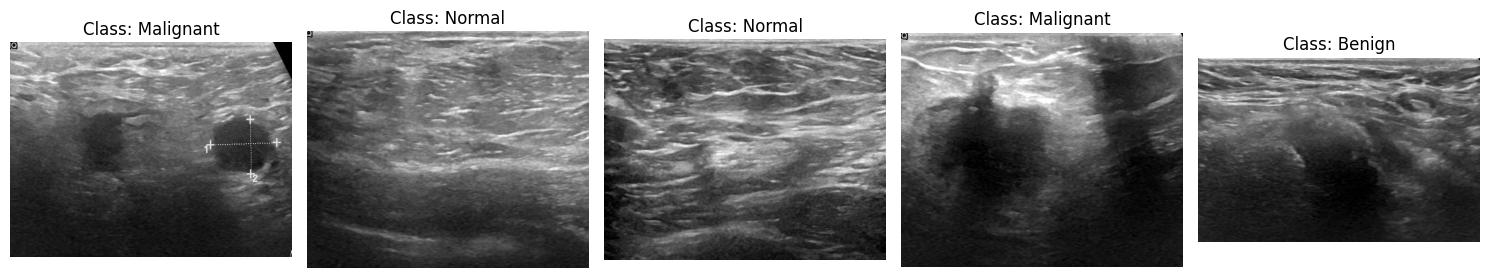

In [ ]:
# Check if train_paths is populated
print(f"Number of images in the dataset: {len(train_paths)}")

# If this is 0, ensure that the paths are correctly loaded in the previous steps
if len(train_paths) > 0:
    show_images_from_paths(train_paths, train_labels)
else:
    print("No images found in the dataset!")


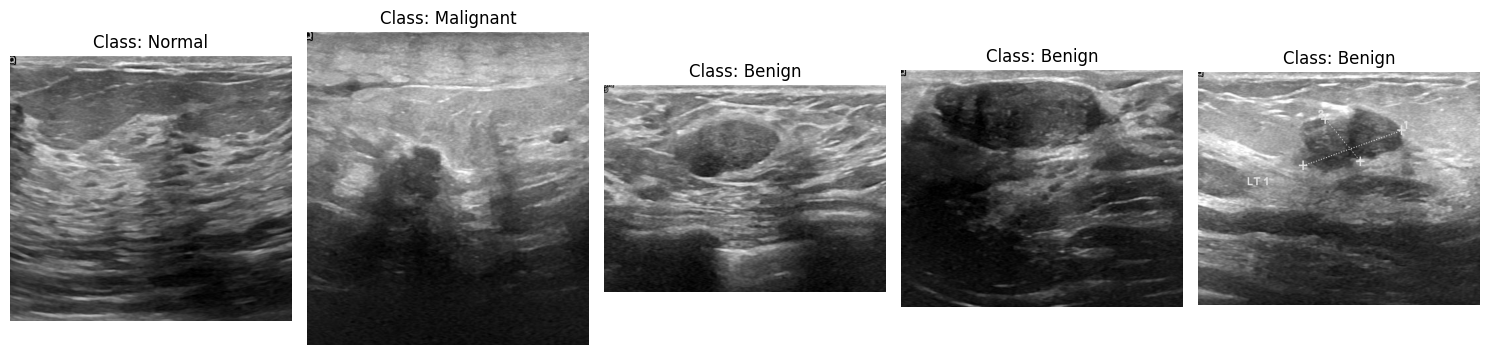

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_images_from_paths(paths, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(paths) - 1)
        img = Image.open(paths[idx])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)  # Display in color (RGB)
        plt.title(f"Class: {labels[idx].capitalize()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show some random images from the dataset
show_images_from_paths(train_paths, train_labels)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=42, stratify=train_labels
)


# Verify the split (optional)
print(f"Number of training images: {len(train_paths_split)}")
print(f"Number of validation images: {len(val_paths)}")


Number of training images: 562
Number of validation images: 100


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the data paths into training and validation (15% validation)
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=42, stratify=train_labels
)

# Initialize ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Apply InceptionV3 preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Initialize ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset_BUSI_Split/train',  # Path to training data
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='sparse'  # For sparse class labels
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset_BUSI_Split/train',  # Same path but using validation data
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='sparse'  # For sparse class labels
)

# If needed, split the val paths and labels for generator manually, as per your directory structure


Found 662 images belonging to 3 classes.
Found 662 images belonging to 3 classes.


In [ ]:
# Compute class weights based on the generator labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Load InceptionV3 base model with pre-trained weights (from ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Second dropout layer
predictions = Dense(3, activation='softmax')(x)  # 3 classes: benign, malignant, normal

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with AdamW optimizer
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Print model summary to see the layers
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_165 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_165[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_164      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_166 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_164[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_166[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_165      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_167 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_165[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_167[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_166      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 73, 73,    │          0 │ activation_166[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_168 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_7[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_168[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_167      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_169 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_167[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_169[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_168      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,853,411 (87.18 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Step decay function for learning rate
def step_decay(epoch, lr):
    drop_rate = 0.7        # Reduce LR by 30%
    epochs_drop = 5        # Every 5 epochs
    if epoch != 0 and epoch % epochs_drop == 0:
        return lr * drop_rate
    return lr

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)



# Train the model with the data generators and class weights
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,

    callbacks=[lr_scheduler],
    class_weight=class_weights_dict  # Apply class weights during training
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 401s 19s/step - loss: 1.8001 - sparse_categorical_accuracy: 0.4076 - val_loss: 0.9002 - val_sparse_categorical_accuracy: 0.5408 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 400s 19s/step - loss: 1.0567 - sparse_categorical_accuracy: 0.5127 - val_loss: 0.7053 - val_sparse_categorical_accuracy: 0.6798 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 385s 19s/step - loss: 0.8158 - sparse_categorical_accuracy: 0.6364 - val_loss: 0.6276 - val_sparse_categorical_accuracy: 0.7492 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 401s 20s/step - loss: 0.8400 - sparse_categorical_accuracy: 0.6117 - val

In [ ]:
model.save("/content/drive/MyDrive/googlenet_20s.h5")
print("✅ Model saved to Google Drive!")

✅ Model saved to Google Drive!


In [ ]:
import os
from PIL import Image
import numpy as np

test_dir = '/content/drive/MyDrive/Dataset_BUSI_Split/test'
categories = ['benign', 'malignant', 'normal']
label_dict = {'benign': 0, 'malignant': 1, 'normal': 2}

test_paths = []
test_labels = []

for label in categories:
    for filename in os.listdir(os.path.join(test_dir, label)):
        if filename.endswith('.png'):
            test_paths.append(os.path.join(test_dir, label, filename))
            test_labels.append(label_dict[label])

# Load and preprocess test images
X_test = []
for path in test_paths:
    img = Image.open(path).convert('RGB')
    img = img.resize((299, 299))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    X_test.append(img_array)

X_test = np.array(X_test)
y_test = np.array(test_labels)


In [ ]:
# Load and preprocess test images (ensure size is 299x299)
X_test = []
for path in test_paths:
    img = Image.open(path).convert('RGB')
    img = img.resize((299, 299))  # Resize to 299x299
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    X_test.append(img_array)

X_test = np.array(X_test)
y_test = np.array(test_labels)

# Now evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - loss: 0.5666 - sparse_categorical_accuracy: 0.7598
Test Loss: 0.6067
Test Accuracy: 0.7458


4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step


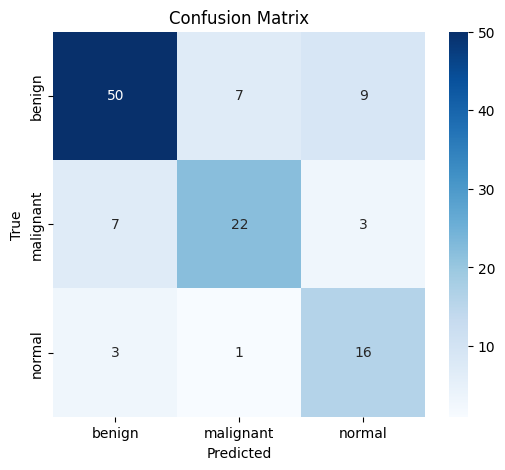

Classification Report:

              precision    recall  f1-score   support

      benign       0.83      0.76      0.79        66
   malignant       0.73      0.69      0.71        32
      normal       0.57      0.80      0.67        20

    accuracy                           0.75       118
   macro avg       0.71      0.75      0.72       118
weighted avg       0.76      0.75      0.75       118



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=categories))


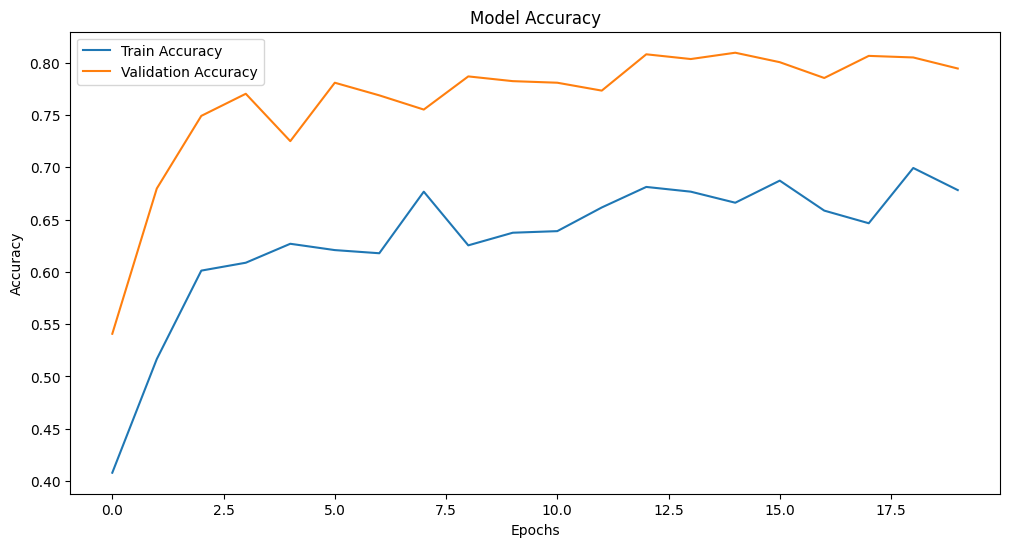

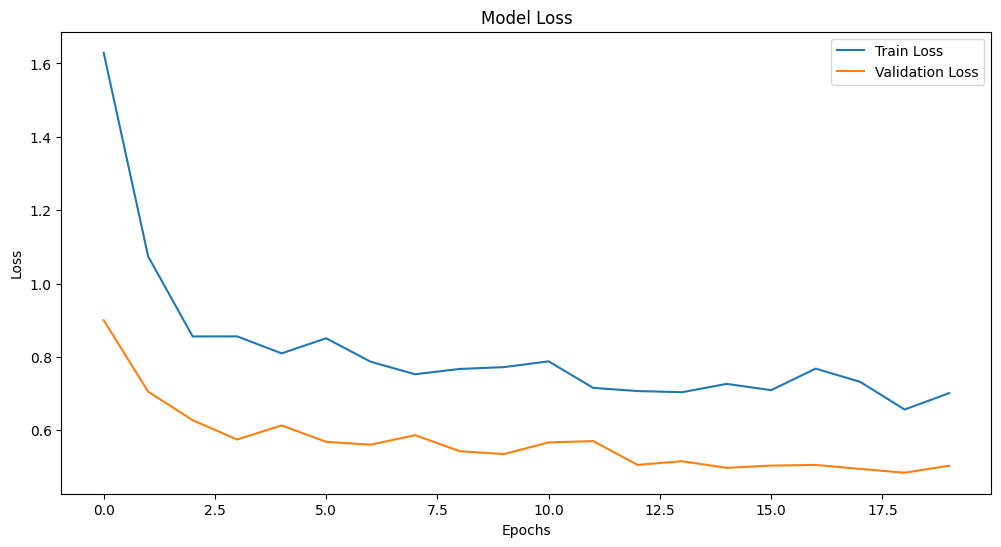

In [ ]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step


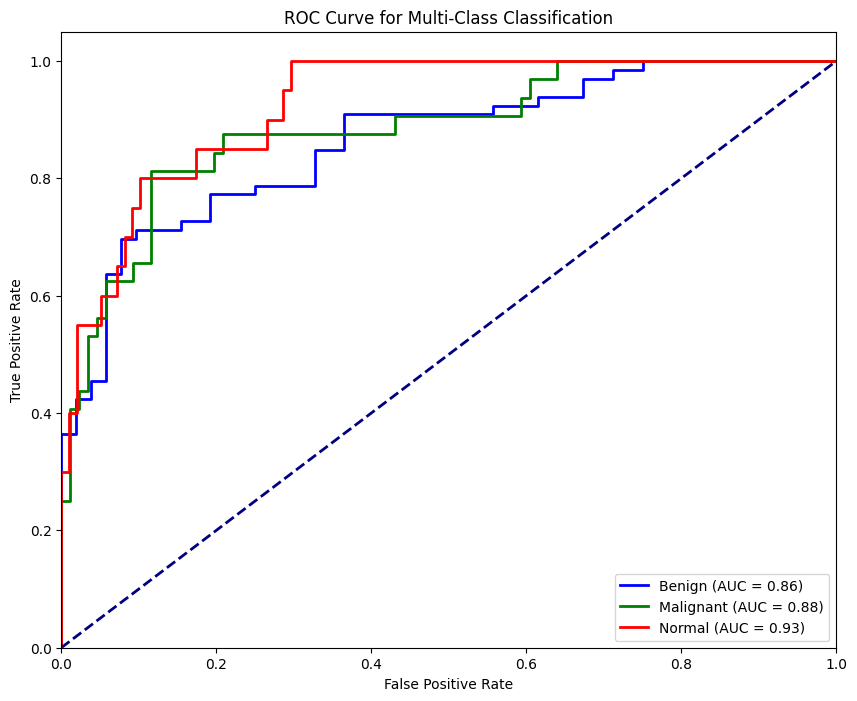

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # One-hot encoding for multiclass
y_pred_bin = model.predict(X_test)

# Calculate ROC for each class
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_pred_bin[:, 0])
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test_bin[:, 1], y_pred_bin[:, 1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test_bin[:, 2], y_pred_bin[:, 2])
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Benign (AUC = {roc_auc:.2f})')
plt.plot(fpr1, tpr1, color='green', lw=2, label=f'Malignant (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='red', lw=2, label=f'Normal (AUC = {roc_auc2:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()
